In [10]:
pip install arxiv

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Bidirectional, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import arxiv  # To fetch papers from arXiv
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import pandas as pd
import time
import arxiv

def arxiv_papers(max_results=6000, wait_time=5):
    keywords = ["Data Science", "Machine Learning", "Deep Learning", "Reinforcement Learning", "Natural Language Processing", "Artificial Intelligence", "Computational Linguistics", "Generative Models", "Predictive Analytics", "Big Data", "Statistical Learning", "Supervised Learning", "Unsupervised Learning", "Neural Networks"]

    categorized_papers = []

    for keyword in keywords:
        print(f"Fetching papers related to: {keyword}")
        query = f'("{keyword}") AND (cat:cs.AI OR cat:cs.LG OR cat:cs.CL OR cat:cs.NE OR cat:stat.ML)'
        search = arxiv.Search(
            query=query,
            max_results=int(max_results/len(keywords)),  # Distribute max_results evenly among keywords
            sort_by=arxiv.SortCriterion.SubmittedDate
        )

        fetched_results = 0  # Track the number of fetched results for each keyword
        try:
            # Fetch papers batch by batch
            for result in search.results():
                if fetched_results >= max_results:
                    break  # Break if max_results reached
                categorized_papers.append({
                    'title': result.title,
                    'summary': result.summary,
                    'categories': result.categories,
                    'keyword': keyword  # Categorize each paper by the current keyword
                })
                fetched_results += 1
                if fetched_results % int(max_results/len(keywords)) == 0:
                    time.sleep(wait_time)  # Wait before making the next API call
        except Exception as e:
            print(f"Error fetching papers for keyword '{keyword}': {e}")

    # Convert the list of categorized papers into a DataFrame
    df_papers = pd.DataFrame(categorized_papers)
    return df_papers



In [5]:
papers = arxiv_papers(max_results=6000)

Fetching papers related to: Data Science


<ipython-input-4-794ea5b31309>:22: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


KeyboardInterrupt: 

In [6]:
papers.to_csv('arxiv.csv')

NameError: name 'papers' is not defined

In [12]:
df = pd.read_csv('arxiv.csv')
df.head()

,Unnamed: 0,title,summary,categories,keyword
0,0,Control-Theoretic Techniques for Online Adapta...,"Deep neural networks (DNNs), trained with grad...","['cs.LG', 'cs.NE', 'cs.RO', 'cs.SY', 'eess.SY']",Data Science
1,1,On the Robustness of Cross-Concentrated Sampli...,Matrix completion is one of the crucial tools ...,"['stat.ML', 'cs.IT', 'cs.LG', 'math.IT', 'math...",Data Science
2,2,GuardML: Efficient Privacy-Preserving Machine ...,Machine Learning (ML) has emerged as one of da...,"['cs.LG', 'cs.CR']",Data Science
3,3,Navigating Dataset Documentations in AI: A Lar...,Advances in machine learning are closely tied ...,"['cs.LG', 'cs.AI']",Data Science
4,4,Cheap Learning: Maximising Performance of Lang...,The field of machine learning has recently mad...,"['cs.CL', 'I.2.7; J.4']",Data Science


In [13]:
# Group the summaries by their keywords and concatenate the summaries in each group
dfg = df.groupby('keyword')['summary'].apply(' '.join).reset_index()

# Display the first few grouped summaries to check the concatenation
dfg.head()

,keyword,summary
0,Artificial Intelligence,Planning has been part of the core pursuit for...
1,Big Data,Emerging Distributed AI systems are revolution...
2,Computational Linguistics,This research explores strategies for steering...
3,Data Science,"Deep neural networks (DNNs), trained with grad..."
4,Deep Learning,Current deep learning models are not designed ...


## Text Summarization

In [15]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from tqdm import tqdm

# Group the summaries by their keywords and concatenate the summaries in each group
df['keyword'] = df['keyword'].str.lower()  # Convert keywords to lowercase for case-insensitive matching
dfg = df.groupby('keyword')['summary'].apply(' '.join).reset_index()

# Load the model and tokenizer
model_name = 'google/pegasus-xsum'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# Assuming prior steps (e.g., loading model, tokenizer, and DataFrame preparation)

keyword_input = input("Enter a keyword to summarize its research concepts: ").lower()

if keyword_input in dfg['keyword'].values:
    summary_texts = dfg[dfg['keyword'] == keyword_input]['summary'].iloc[0]

    # If the text is too long, consider splitting it into manageable parts
    # Example: Splitting by sentences or paragraphs could be more meaningful
    parts = [summary_texts[i:i+50000] for i in range(0, len(summary_texts), 50000)]

    summaries = []
    for part in parts:
        inputs = tokenizer.encode("summarize: " + part, return_tensors="pt", max_length=512, truncation=True)
        summary_ids = model.generate(inputs,
                                     max_length=120,
                                     min_length=50,
                                     length_penalty=2.5,
                                     num_beams=6,
                                     early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)

    # Combine summaries or handle them as needed
    final_summary = " ".join(summaries)
    print("\nGenerated Summary:")
    print(final_summary)
else:
    print("Keyword not found in dataset. Please try another one.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

Enter a keyword to summarize its research concepts: reinforcement learning

Generated Summary:
This paper presents a framework for building neural network-based learning models that can overcome compositional constraints, as well as other areas of research such as reinforcement learning, sentiment analysis, and natural language processing (NLP) and speech recognition, among others. Reinforcement learning (RL) is one of the most popular approaches for training machine learning algorithms, but its performance has been under scrutiny due to its high-dimensionality and the complexity involved in correlating visuotactile data with the dynamic environment. In this paper, we present Hi-Core, an artificial intelligence (AI) system designed to learn complex repetitive task (CRL) from a library of low-level policy knowledge (LPL). The treatment of methods, problems, and applications presented here is poised to inform and inspire practitioners and researchers to develop impactful data-driven sens

In [16]:
def check_redundancy(summary):
    sentences = set()
    for sentence in summary.split('.'):
        if sentence in sentences:
            return True  # Redundancy found
        sentences.add(sentence)
    return False  # No redundancy

is_redundant = check_redundancy(final_summary)
print("Is summary redundant?:", is_redundant)

Is summary redundant?: False


In [17]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a161514145fde1cd1bf811ef2c240338e711d7b38f76f97ff889ae14a6195fb7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [18]:

from rouge_score import rouge_scorer

# Assuming 'df' is your DataFrame and 'final_summary' is the summary generated by your model
# Let's say your keyword is 'data science'
keyword = 'data science'
keyword_summaries = df[df['keyword'].str.lower() == keyword]['summary'].tolist()

# Join the keyword-specific summaries into a single string to use as reference
reference_text = ' '.join(keyword_summaries)

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute ROUGE scores
scores = scorer.score(reference_text, final_summary)

print("ROUGE-1 score:", scores['rouge1'])
print("ROUGE-2 score:", scores['rouge2'])
print("ROUGE-L score:", scores['rougeL'])

ROUGE-1 score: Score(precision=0.9595588235294118, recall=0.006421138091372057, fmeasure=0.012756909992912829)
ROUGE-2 score: Score(precision=0.6427255985267035, recall=0.004293112568117796, fmeasure=0.008529253629209638)
ROUGE-L score: Score(precision=0.7242647058823529, recall=0.004846606145595001, fmeasure=0.009628778806911216)


### Trend Analysis and Research Gap Identification

In [19]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 3.7 MB/s eta 0:00:00


In [21]:
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import IsolationForest
import pandas as pd  # Assuming you have a DataFrame `df`

# Load the pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Initialize a dictionary to store the titles of anomalous papers
anomalous_titles_dict = {}

# Number of keywords to input
num_keywords = 4

for i in range(num_keywords):
    # Take user input for each keyword
    keyword_input = input(f"Enter keyword {i+1} to identify niche concepts/research gaps: ").lower()

    # Filter the DataFrame based on the keyword
    df_filtered = df[df['keyword'].str.lower() == keyword_input]

    # Generate embeddings for the filtered summaries
    embeddings = model.encode(df_filtered['summary'].tolist(), convert_to_tensor=False)

    # Apply Isolation Forest for anomaly detection
    clf = IsolationForest(n_estimators=13, random_state=42)
    anomalies = clf.fit_predict(embeddings)

    # Identifying indexes of anomalies
    anomaly_indexes = [i for i, val in enumerate(anomalies) if val == -1]

    # Extracting the titles of the papers identified as anomalies
    anomaly_titles = df_filtered.iloc[anomaly_indexes]['title'].tolist()

    # Store results in dictionary
    anomalous_titles_dict[keyword_input] = anomaly_titles

Enter keyword 1 to identify niche concepts/research gaps: data science
Enter keyword 2 to identify niche concepts/research gaps: artificial intelligence
Enter keyword 3 to identify niche concepts/research gaps: reinforcement learning
Enter keyword 4 to identify niche concepts/research gaps: deep learning


In [22]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text_list):
    preprocessed_text = []
    for text in text_list:
        words = word_tokenize(text.lower())  # Tokenize and convert to lower case
        filtered_words = [word for word in words if word not in stop_words and word.isalnum()]
        preprocessed_text.extend(filtered_words)
    return preprocessed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


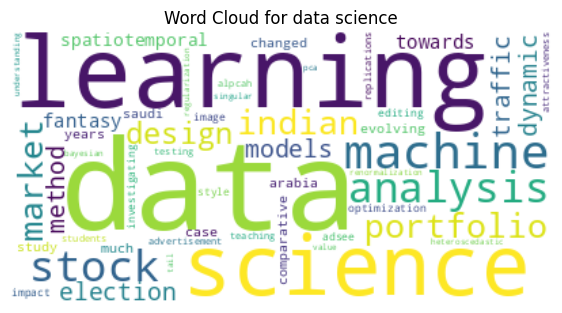

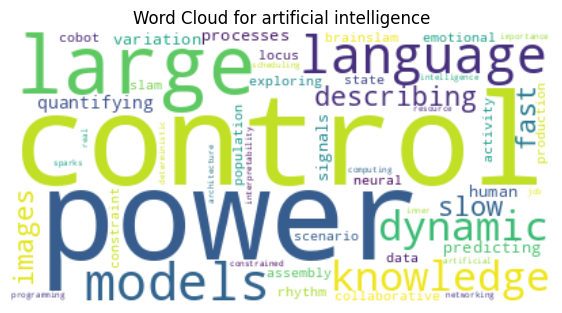

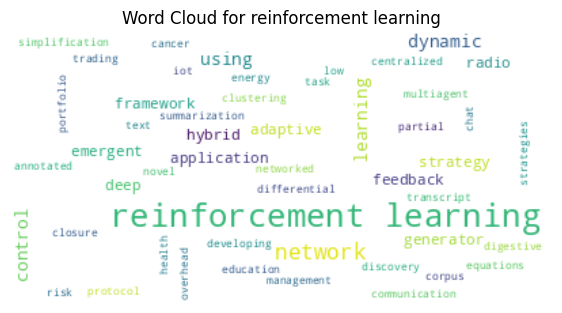

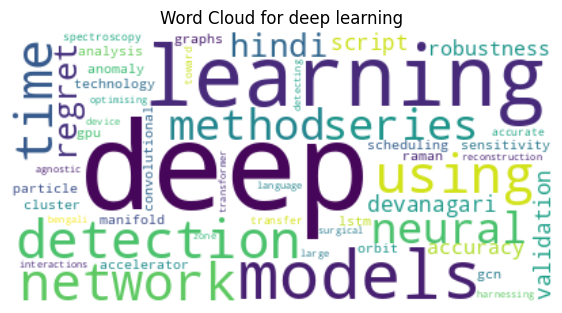

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for keyword, titles in anomalous_titles_dict.items():
    preprocessed_titles = preprocess_text(titles)
    text = ' '.join(preprocessed_titles)
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=50).generate(text)

    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {keyword}')
    plt.show()
    print("\n")

In [24]:
anomalous_titles_dict

{'data science': ['The evolving of Data Science and the Saudi Arabia case. How much have we changed in 13 years?',
  'A Comparative Study of Portfolio Optimization Methods for the Indian Stock Market',
  'AdSEE: Investigating the Impact of Image Style Editing on Advertisement Attractiveness',
  'In-class Data Analysis Replications: Teaching Students while Testing Science',
  'ALPCAH: Sample-wise Heteroscedastic PCA with Tail Singular Value Regularization',
  'Bayesian Renormalization',
  'Understanding cirrus clouds using explainable machine learning',
  'Model-Driven Quantum Federated Learning (QFL)',
  'Infinite Action Contextual Bandits with Reusable Data Exhaust',
  'Dialectograms: Machine Learning Differences between Discursive Communities',
  'Design and analysis of tweet-based election models for the 2021 Mexican legislative election',
  'AMD-DBSCAN: An Adaptive Multi-density DBSCAN for datasets of extremely variable density',
  'CBLab: Supporting the Training of Large-scale Tra

In [ ]:
dfg